In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./graphs

%tensorflow_version 2.x

!apt-get update -y
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt install xvfb

!dpkg --configure -a
!pip install tqdm
!pip install box2d  
!pip install -q tf-agents

#http://fnl.es/a-quick-reference-for-working-with-tensorflow.html

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-ut

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pyvirtualdisplay import Display

import tensorflow.compat.v1 as tf
from collections import deque
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input , BatchNormalization, Concatenate, LayerNormalization, LSTM,Reshape
from tensorflow.keras.optimizers import Adam
import random
import tqdm
import pandas as pd

tf.disable_eager_execution()
from google.colab import drive
drive.mount('/content/drive')
import math
import time

from tf_agents.utils import  value_ops

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
tf.reset_default_graph()
epsilon = 0

#https://stackoverflow.com/questions/49432852/estimating-high-resolution-images-from-lower-ones-using-a-keras-model-based-on-c
#https://stackoverflow.com/questions/49603498/convolution2d-lstm-versus-convlstm2d
#https://stackoverflow.com/questions/49146881/passing-cnn-outputs-to-lstm-in-tensorflow

In [4]:
class Agent:
  def __init__(self, name, state_shape, n_actions, sess, reuse=False):
    """A simple actor-critic agent"""
    with tf.variable_scope(name, reuse=reuse):

      # Prepare neural network architecture
      inputs = Input(shape=state_shape)#https://github.com/bentrevett/pytorch-rl/blob/master/4a%20-%20Generalized%20Advantage%20Estimation%20(GAE)%20%5BLunarLander%5D.ipynb
      x =  Dense(128, activation='relu', name ="inp1")(inputs)#Dense(128, activation='relu', name ="inp1")(inputs)
      #x = Dropout(0.4)(x)
      #x = Dense(64, activation='relu', name ="inp2")(x)
      #x = Dropout(0.2)(x)
      rnn_in = Reshape((1 ,x.shape[1]), input_shape=x.shape)(x)
      x = LSTM(64, return_sequences=False, name ="lstm_enc_1")(rnn_in)#LSTM(64, return_sequences=False, name ="lstm_enc_1")(rnn_in)
      
      logits = Dense(n_actions, activation='linear', name ="logits")(x)
      state_value = Dense(1, activation='linear', name ="v")(x)
      self.network = Model(inputs=inputs, outputs=[logits, state_value])

      self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
      self.agent_outputs = self.symbolic_step(self.state_t)
      
  def symbolic_step(self, state_t):
    l,s = self.network(state_t)
    
    logits = l
    state_values = s[:,0]
    
    return logits, state_values
  
  def step(self, state_t):
      """Same as symbolic step except it operates on numpy arrays"""
      return sess.run(self.agent_outputs, {self.state_t: state_t})
  
  def sample_actions(self, agent_outputs,epsilon):
      """pick actions given numeric agent outputs (np arrays)"""
      if np.random.random() < epsilon:
        return np.random.randint(n_actions, size=nEnviroment)

      logits, state_values = agent_outputs
      policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
      return np.array([np.random.choice(len(p), p=p) for p in policy])


In [5]:
class LunarLanderA3C:
  def __init__(self, sess,env, gae):
    self.sess =sess
    
    self.filepath = "/content/drive/My Drive/Colab Notebooks/RL/LunarLander/data.txt"
    self.batch_size =10
    self.gae_steps=0
    self.gae_size = 20 #20 - 500k steps to done #50 #25 
    self.memory = deque(maxlen= 500)
    self.Training= 2000000#400000
    self.learning_rate= 0.0008#0.0008
    self.entropy_factor = 0.001

    self.rewards_history = []
    self.entropy_history = []
    self.actor_history =[]
    self.critic_history =[]
    self.advantage_history = []
    self.target_history =[]
    self.v_history =[]
    self.actionList =[]
    
    self.reward_step =0
    self.writer = tf.summary.FileWriter('./graphs', sess.graph)

    self.is_gae = gae
    self.env = env
    self.obs_shape = self.env.observation_space.shape
    self.n_actions = self.env.action_space.n

    print("Observation shape:", self.obs_shape)
    print("Num actions:", self.n_actions)

    self.agent = Agent("agent", self.env.observation_space.shape, self.env.action_space.n, self.sess)

    self.states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape), name="states_ph")    
    self.next_states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape), name="next_states_ph")    
    self.actions_ph = tf.placeholder('int32', (None,), name="actions_ph")    
    self.rewards_ph = tf.placeholder('float32', (None,), name="rewards_ph")    
    self.is_done_ph = tf.placeholder('float32', (None,), name="is_done_ph")    
    self.game_reward = tf.placeholder('float32', [None,], name="game_reward")    
    self.counter = tf.placeholder('float32', 1, name="counter")    

    # logits[n_envs, n_actions] and state_values[n_envs, n_actions]
    self.logits, self.state_values = self.agent.symbolic_step(self.states_ph)
    self.next_logits, self.next_state_values = self.agent.symbolic_step(self.next_states_ph)

    # probabilities and log-probabilities for all actions
    self.probs = tf.nn.softmax(self.logits, axis=-1)            # [n_envs, n_actions]
    self.logprobs = tf.nn.log_softmax(self.logits, axis=-1)     # [n_envs, n_actions]

    # log-probabilities only for agent's chosen actions
    self.logp_actions = tf.reduce_sum(self.logprobs * tf.one_hot(self.actions_ph, self.n_actions), axis=-1) # [n_envs,]
    self.gamma = 0.99
    self.entropy = -tf.reduce_sum(self.probs * self.logprobs, 1, name="entropy")

    if self.is_gae:

      self.final_value= self.next_state_values[-1]
      self.discounts = (1 - self.is_done_ph)*self.gamma
      
      self.adv = value_ops.generalized_advantage_estimation( self.state_values, self.final_value, self.discounts, self.rewards_ph  , td_lambda=0.99, time_major=True)
      self.tg = value_ops.discounted_return(self.rewards_ph, self.discounts, self.final_value)

      self.gae = self.adv #tf.reverse(tf.reshape(self.adv,(self.counter[0],)), axis = [0])
      self.td_target = self.tg #tf.reverse(tf.reshape(self.tg,(self.counter[0],)), axis = [0])

      self.actor_loss = -tf.reduce_mean(self.logp_actions * tf.stop_gradient(self.gae), axis=0) - self.entropy_factor * tf.reduce_mean(self.entropy, axis=0)
      self.critic_loss = tf.reduce_mean((self.state_values - tf.stop_gradient(self.td_target))**2, axis=0)

      print("state_values",self.state_values)
      print("next_state_values",self.next_state_values)
      print("probs",self.probs)
      print("logprobs",self.logprobs)
      print("logp_actions",self.logp_actions)
      print("entropy",self.entropy)
      print("td_target",self.td_target)
      print("gae",self.gae)
      print("actor_loss",self.actor_loss)
      print("critic_loss",self.critic_loss)
      self.summary_gae = tf.summary.scalar('gae', tf.reduce_mean(self.gae, axis=-1))
      self.summary_target = tf.summary.scalar('target', tf.reduce_mean(self.td_target, axis=-1))

    else:
      self.next_state_values = self.next_state_values * (1 - self.is_done_ph)
      self.advantage = self.rewards_ph + self.gamma*self.next_state_values - self.state_values
      self.target_state_values = self.rewards_ph+self.gamma*self.next_state_values
      self.actor_loss = -tf.reduce_mean(self.logp_actions * tf.stop_gradient(self.advantage), axis=0) - self.entropy_factor * tf.reduce_mean(self.entropy, axis=0)
      self.critic_loss = tf.reduce_mean((self.state_values - tf.stop_gradient(self.target_state_values))**2, axis=0)
      self.summary_target = tf.summary.scalar('target', tf.reduce_mean(self.next_state_values, axis=-1))
      self.summary_adv = tf.summary.scalar('advantage_', tf.reduce_mean(self.advantage, axis=-1))

    self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.actor_loss + self.critic_loss)
    #https://github.com/HorizonRobotics/alf/pull/14/files/013c2c2c8a8cc678075b852daa90fed21892cf0f
    #https://github.com/HorizonRobotics/alf/pull/12/files/bf1c4018a305a020af3268366fe8fb06d7d6bce3
    #https://alf.readthedocs.io/en/latest/_modules/alf/algorithms/ppo_algorithm.html
    #https://www.programcreek.com/python/?CodeExample=compute%20advantages
    
    self.summary_ent = tf.summary.scalar('entropy_',tf.reduce_mean(self.entropy, axis=-1))
    self.summary_act_loss = tf.summary.scalar('actor_loss_', self.actor_loss)
    self.summary_crit_loss = tf.summary.scalar('critic_loss_', self.critic_loss)
    self.summary_v = tf.summary.scalar('state_values', tf.reduce_mean(self.state_values, axis=-1))
    self.summary_r = tf.summary.scalar('mean_reward', tf.reduce_mean(self.game_reward, axis=-1))
    

  def evaluate(self, n_games=1):
      """Plays an a game from start till done, returns per-game rewards """
      game_rewards = []
      for _ in range(n_games):
          state = self.env.reset()

          total_reward = 0
          while True:
              action = self.agent.sample_actions(self.agent.step([state]),0)[0]
              state, reward, done, info = self.env.step(action)
              total_reward += reward
              if done:
                  break
          game_rewards.append(total_reward)

      avr_reward =sess.run(self.summary_r, { self.game_reward: np.array(game_rewards).reshape(n_games,)})
                           
      self.writer.add_summary(avr_reward,self.reward_step)
      self.reward_step +=1

      return game_rewards


  def get_sample(self):
    #batch = random.sample(self.memory, self.gae_size)

    s = np.array([each[0] for each in self.memory])
    a = [each[1] for each in self.memory]
    s_ = np.array([each[2] for each in self.memory])
    r = [each[3] for each in self.memory]
    dones = [each[4] for each in self.memory]
    step = [each[5] for each in self.memory]
    return s,a,r,s_,dones,step
  #https://docs.google.com/spreadsheets/d/1DN7O7JZEmdUhmF0fmQT0JcNKe3eseuCKUnRwl27uveA/edit#gid=0
  #https://github.com/higgsfield/RL-Adventure-2/blob/master/2.gae.ipynb

  def train_gae(self):

    if len(self.memory) < self.gae_size:
      return

    s,a,r,s_,dones,steps = self.get_sample()
    
    ent = []
    actors =[]
    critics=[]
    targets_=[]
    states_v=[]
    gae_l=[]
    
    for j in range(self.batch_size):
      counter =0
      s__temp=[]
      s_temp=[]
      r_temp =[]
      dones_temp=[]
      a_temp=[]

      for x in range(len(r)):
        r_temp.append(r[x][j] )
        s_temp.append(s[x,j]) 
        dones_temp.append((dones[x][j]) )
        s__temp.append(s_[x,j])
        a_temp.append(a[x][j])
        counter +=1
        self.actionList.append(a[x][j])

        if dones[x][j] ==1:
          break

      s_temp_arr= (np.array(s_temp)).reshape((counter,self.env.observation_space.shape[0]))
      s__temp_arr= (np.array(s__temp)).reshape((counter,self.env.observation_space.shape[0]))

      feed_dict = {
              self.states_ph: s_temp_arr,
              self.actions_ph: a_temp,
              self.next_states_ph: s__temp_arr,
              self.rewards_ph: r_temp,
              self.is_done_ph: dones_temp,
              self.counter : [counter]
          }
      _, ent_t,act,crit,targ,target, gae, v,sum_ent,sum_act_loss,sum_crit_loss,sum_v,sum_gae = sess.run([self.train_step, self.entropy,self.actor_loss ,self.critic_loss,self.tg,self.td_target,self.gae,#self.adv,self.final_value, self.discounts,    ,adv,final,disc
                                              self.state_values,self.summary_ent,self.summary_act_loss,self.summary_crit_loss,
                                              self.summary_v,self.summary_gae], feed_dict)


      self.writer.add_summary(sum_gae, self.gae_steps)
      self.writer.add_summary(sum_ent, self.gae_steps)
      self.writer.add_summary(sum_act_loss, self.gae_steps)
      self.writer.add_summary(sum_crit_loss, self.gae_steps)
      self.writer.add_summary(sum_v, self.gae_steps)
      self.gae_steps +=1


      ent.append(np.mean(ent_t))
      actors.append(np.mean(act))
      critics.append(np.mean(crit))
      targets_.append(np.mean(targ))
      states_v.append(np.mean(v))
      gae_l.append(np.mean(gae))

    self.entropy_history.append(np.mean(ent))
    self.actor_history.append(np.mean(actors))
    self.critic_history.append(np.mean(critics))
    self.target_history.append(np.mean(targets_))
    self.v_history.append(np.mean(states_v))
    self.advantage_history.append(np.mean(gae_l))
    self.memory.clear()

  def train(self,batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,step):

    feed_dict = {
            self.states_ph: batch_states,
            self.actions_ph: batch_actions,
            self.next_states_ph: batch_next_states,
            self.rewards_ph: batch_rewards,
            self.is_done_ph: batch_done,
        }

    _, ent_t,act,crit,adv,targ,v,sum_adv,sum_ent,sum_target,sum_act_loss,sum_crit_loss,sum_v = sess.run([self.train_step, self.entropy,self.actor_loss ,self.critic_loss,self.advantage,
                                             self.target_state_values,self.state_values,
                                             self.summary_adv,self.summary_ent,self.summary_target,self.summary_act_loss,self.summary_crit_loss,
                                             self.summary_v], feed_dict)

    self.writer.add_summary(sum_adv, step)
    self.writer.add_summary(sum_ent, step)
    self.writer.add_summary(sum_target, step)
    self.writer.add_summary(sum_act_loss, step)
    self.writer.add_summary(sum_crit_loss, step)
    self.writer.add_summary(sum_v, step)

    self.entropy_history.append(np.mean(ent_t))
    self.actor_history.append(np.mean(act))
    self.critic_history.append(np.mean(crit))
    self.advantage_history.append(np.mean(adv))
    self.target_history.append(np.mean(targ))
    self.v_history.append(np.mean(v))
    for a in batch_actions:
      self.actionList.append(a)

  def ewma(self,x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

  def plots(self):
    ipythondisplay.clear_output(wait=True)
    plt.figure(figsize=[35,13])
    plt.subplot(2,4,1)
    plt.plot(self.rewards_history, label='reward')
    plt.plot(self.ewma(np.array(self.rewards_history), span=10), marker='.', label='rewards ewma@10')
    plt.title("Session rewards"); plt.grid(); plt.legend()

    plt.subplot(2,4,2)
    plt.plot(self.actor_history, label='Actor Loss')
    plt.plot(self.ewma(np.array(self.actor_history), span=10), marker='.', label='Actor Loss ewma@10')
    plt.title("Policy Function"); plt.grid(); plt.legend()  

    plt.subplot(2,4,3)
    plt.plot(self.entropy_history, label='Entropy')
    plt.plot(self.ewma(np.array(self.entropy_history), span=10), marker='.', label='Entropy ewma@10')
    plt.title("Policy Function"); plt.grid(); plt.legend()      
    
    plt.subplot(2,4,4)
    plt.plot(self.target_history, label='Target ')
    plt.plot(self.v_history, label='V')
    plt.title("Target/V"); plt.grid(); plt.legend()

    plt.subplot(2,4,5)
    plt.plot(self.advantage_history, label='Advantage')
    plt.title("Advantage"); plt.grid(); plt.legend()  

    plt.subplot(2,4,6)
    plt.plot(self.critic_history, label='Critic Loss')
    plt.plot(self.ewma(np.array(self.critic_history), span=10), marker='.', label='Critic Loss ewma@10')
    plt.title("Value function"); plt.grid(); plt.legend()   

    plt.subplot(2,4,7)
    plt.plot(self.actionList, label='Actions')
    plt.title("Actions"); plt.grid(); plt.legend()  

    plt.show()

In [6]:

class EnvBatch:
  def __init__(self, n_envs = 10):
    """ Creates n_envs environments and babysits them for ya' """
    self.envs = [gym.make("LunarLander-v2") for _ in range(n_envs)]
    
  def reset(self):
    """ Reset all games and return [n_envs, *obs_shape] observations """
    return np.array([env.reset() for env in self.envs])
  
  def step(self, actions):
    """
    Send a vector[batch_size] of actions into respective environments
    :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
    """
    results = [env.step(a) for env, a in zip(self.envs, actions)]
    new_obs, rewards, done, infos = map(np.array, zip(*results))

    # reset environments automatically
    for i in range(len(self.envs)):
      if done[i]:
        new_obs[i] = self.envs[i].reset()
    
    return new_obs, rewards, done, infos


In [7]:
sess = tf.Session(graph= tf.get_default_graph())
RESET = 1
is_gae = True



In [8]:
display = Display(visible=0, size=(400, 300))
display.start()
env = gym.make("LunarLander-v2")
lunarlanderA3C = LunarLanderA3C(sess,env,is_gae)


Observation shape: (8,)
Num actions: 4
state_values Tensor("strided_slice:0", shape=(None,), dtype=float32)
next_state_values Tensor("strided_slice_1:0", shape=(None,), dtype=float32)
probs Tensor("Softmax:0", shape=(None, 4), dtype=float32)
logprobs Tensor("LogSoftmax:0", shape=(None, 4), dtype=float32)
logp_actions Tensor("Sum:0", shape=(None,), dtype=float32)
entropy Tensor("Neg:0", shape=(None,), dtype=float32)
td_target Tensor("StopGradient_2:0", shape=(None,), dtype=float32)
gae Tensor("StopGradient:0", shape=(None,), dtype=float32)
actor_loss Tensor("sub_1:0", shape=(), dtype=float32)
critic_loss Tensor("Mean_2:0", shape=(), dtype=float32)


In [9]:

if (RESET == 1):
  # ************ RESET everything **************************
  sess.run(tf.global_variables_initializer())
  saver = tf.train.Saver()
  #f=open(lunarlanderA3C.filepath, "w")
  #f.write("")
  #f.close()
  !rm -r /content/drive/My\ Drive/Colab\ Notebooks/RL/LunarLander/graphs/*
else:
  # ************ LOAD everything **************************
  epsilon = 0.01 
  saver = tf.train.Saver()
  saver.restore(sess, tf.train.latest_checkpoint('/content/drive/My Drive/Colab Notebooks/RL/LunarLander/'))
  !cp -r  /content/drive/My\ Drive/Colab\ Notebooks/RL/LunarLander/graphs/ /content/
  f=open(lunarlanderA3C.filepath,'r')
  for line in f:
    lunarlanderA3C.rewards_history.append(float(line.split()[0]))
    lunarlanderA3C.actor_history.append(float(line.split()[1]))
    lunarlanderA3C.entropy_history.append(float(line.split()[2]))
    lunarlanderA3C.target_history.append(float(line.split()[3]))
    lunarlanderA3C.v_history.append(float(line.split()[4]))
    lunarlanderA3C.advantage_history.append(float(line.split()[5]))
    lunarlanderA3C.critic_history.append(float(line.split()[6]))
  f.close()
  lunarlanderA3C.plots()

# Validate
rewards = lunarlanderA3C.evaluate(n_games=3)
print(rewards)

env_batch = EnvBatch(lunarlanderA3C.batch_size)
batch_states = env_batch.reset()
batch_actions = lunarlanderA3C.agent.sample_actions(lunarlanderA3C.agent.step(batch_states),0)
batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

#Initialize
env_batch = EnvBatch(lunarlanderA3C.batch_size)
batch_states = env_batch.reset()

[-406.7177375209927, -219.23055545254962, -115.03448403227989]
State shape: (10, 8)
Actions: [0 2 1 3 2 2 3 1 0 3]
Rewards: [-0.95856171 -2.37339237 -1.69976541  0.1179488  -5.28071155  5.05254709
 -2.01609777  0.48146683 -0.35441553 -0.89799557]
Done: [False False False False False False False False False False]


In [10]:
!cp -r  /content/drive/My\ Drive/Colab\ Notebooks/RL/LunarLander/graphs /content/

In [11]:
"""%tensorboard --logdir graphs
time.sleep(15)"""

'%tensorboard --logdir graphs\ntime.sleep(15)'

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
 44%|████▍     | 880000/2000000 [3:43:13<2:59:26, 104.02it/s]

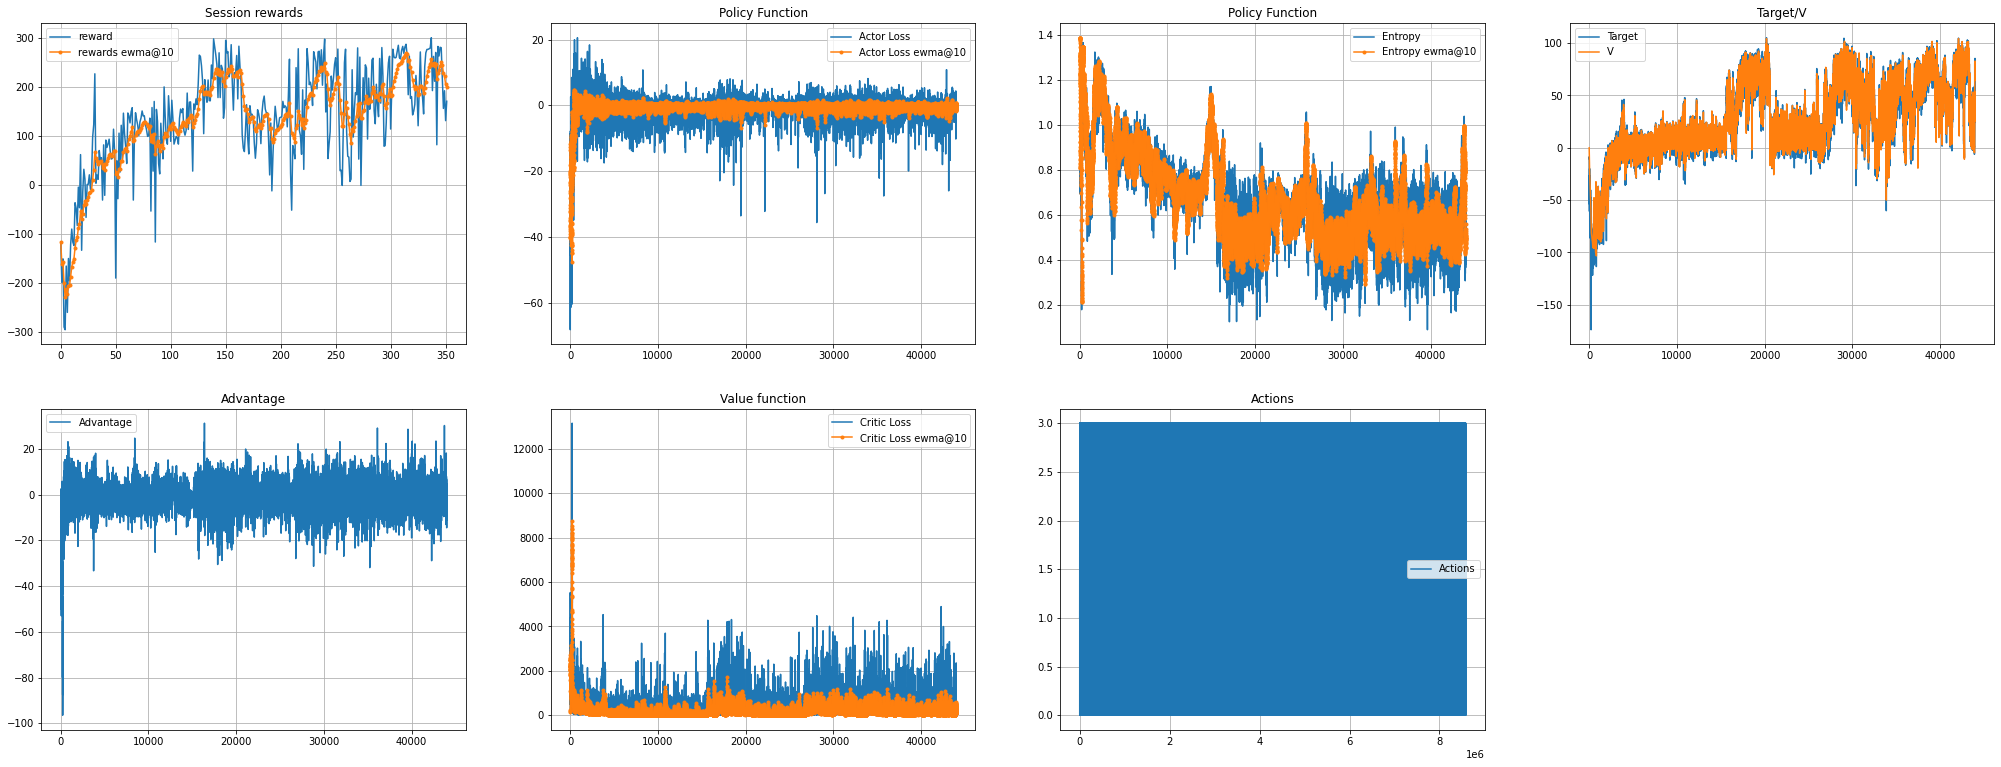

 44%|████▍     | 890000/2000000 [3:45:20<4:41:02, 65.83it/s] 

Your agent reached the objetive


In [12]:
#f=open(lunarlanderA3C.filepath, "w")
epsilon=0
with tqdm.trange(len(lunarlanderA3C.entropy_history), lunarlanderA3C.Training) as t:
  for i in t:
    agent_outputs = lunarlanderA3C.agent.step(batch_states)
    batch_actions = lunarlanderA3C.agent.sample_actions(agent_outputs,epsilon)
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    # Reward scaling. See above for explanation.
    if is_gae :
      lunarlanderA3C.memory.append([batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,i])
      lunarlanderA3C.train_gae()
    else:
      lunarlanderA3C.train(batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,i)


    batch_states = batch_next_states

    if len(lunarlanderA3C.rewards_history)> 100 :
        if np.mean(lunarlanderA3C.rewards_history[-100:]) >= 200 :
          print("Your agent reached the objetive")
          break

    if i % 500 == 0:

      if i % 20000 == 0:
        !cp -r  /content/graphs /content/drive/My\ Drive/Colab\ Notebooks/RL/LunarLander/
        saver.save(sess, "/content/drive/My Drive/Colab Notebooks/RL/LunarLander/model.h5")
        lunarlanderA3C.plots()

      if i % 2500 == 0:       
        lunarlanderA3C.rewards_history.append(np.mean(lunarlanderA3C.evaluate(n_games=3)))
      
      """if i %10000 ==0:
        f.close()
        f=open(lunarlanderA3C.filepath, "a+")
      
      if i> 0:
        f.write("%f %f %f %f %f %f %f\n" % (lunarlanderA3C.rewards_history[-1],lunarlanderA3C.actor_history[-1], lunarlanderA3C.entropy_history[-1],
                                          lunarlanderA3C.target_history[-1],lunarlanderA3C.v_history[-1],lunarlanderA3C.advantage_history[-1],lunarlanderA3C.critic_history[-1]))"""
      
#f.close()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


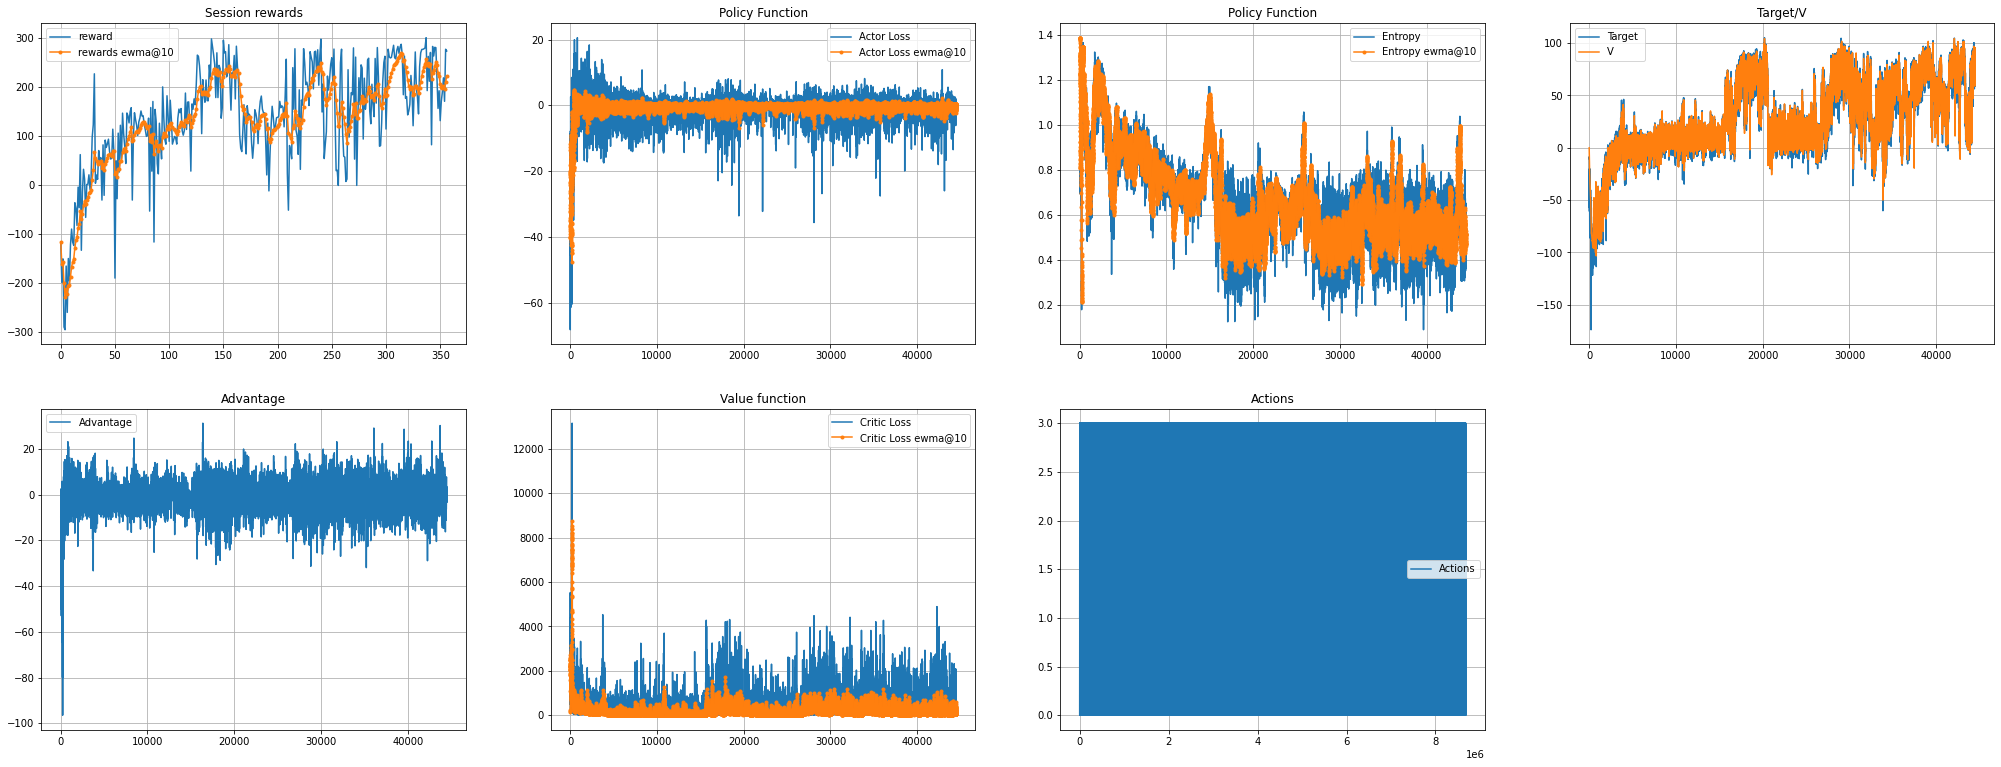

In [13]:
!cp -r  /content/graphs /content/drive/My\ Drive/Colab\ Notebooks/RL/LunarLander/
saver.save(sess, "/content/drive/My Drive/Colab Notebooks/RL/LunarLander/model.h5")
lunarlanderA3C.plots()


In [14]:
display = Display(visible=0, size=(400, 300))
display.start()

def evaluate2(agent, env, n_games=1):
  """Plays an a game from start till done, returns per-game rewards """
  game_rewards = []
  for _ in range(n_games):
      state = env.reset()

      total_reward = 0
      while True:
          action = agent.sample_actions(agent.step([state]),0)[0]
          state, reward, done, info = env.step(action)
          total_reward += reward
          if done:
              break

      game_rewards.append(total_reward)
  return game_rewards

env_monitor = gym.wrappers.Monitor(env, directory="/content/drive/My Drive/Colab Notebooks/RL/LunarLander/videos", force=True)
final_rewards = evaluate2(lunarlanderA3C.agent, env_monitor, n_games=100)
env_monitor.close()

print("Final mean reward:", np.mean(final_rewards))

Final mean reward: 261.0960847818098
